In [2]:
import pandas as pd
import numpy as np
import pylab as plt
import geopandas as gpd
%pylab inline

import warnings
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/nkwjones/anaconda3/envs/arcgis2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [20]:
df = gpd.read_file('/Users/nkwjones/Desktop/temp/hospitals/HT_100_yr_1.shp')

cols_100=['Ile_a_Vach', 'Haiti_Nort', 'Haiti_No_1', 'Haiti_No_2', 'Haiti_Sout',
       'Haiti_Lowe', 'Haiti_Uppe', 'Haiti_So_1', 'Haiti_So_2']
cols_25=['25_1','25_2','25_3','25_4',
 '25_5','25_6','25_7','25_8','25_9']
cols_5=['5_1','5_2','5_3','5_4',
 '5_5','5_6','5_7','5_8','5_9']
df['d100yr'] = df[cols_100].max(axis=1)
df['d25yr'] = df[cols_25].max(axis=1)
df['d5yr'] = df[cols_5].max(axis=1)

df.drop(cols_100,inplace=True,axis=1)
df.drop(cols_25,inplace=True,axis=1)
df.drop(cols_5,inplace=True,axis=1)

df.replace(-9999,0,inplace=True)
df.head()

,area,id,lat,lon,name,elevation,ORIG_FID,geometry,d100yr,d25yr,d5yr
0,1298.524858,48564191.0,19.946933,-72.822550,CENTRE DE SANTE SOLEIL,10.640075,-1,POINT (-72.82254959999995 19.94693300000006),0.196896,0.000000,0.000000
1,3448.183656,130506153.0,19.944752,-72.775430,Health care,20.813026,-1,POINT (-72.77543039999995 19.94475180000006),0.757989,0.693234,0.151303
2,303.168177,629031325.0,19.944923,-72.774908,Centre Medical de Beraca,20.272068,-1,POINT (-72.77490839999996 19.94492340000005),0.000000,0.000000,0.000000
3,303.168177,631601608.0,19.945180,-72.821013,DISPENSAIRE NOTRE DAME DE FATIMA,25.336763,-1,POINT (-72.82101339999997 19.94517990000003),0.000000,0.000000,0.000000
4,303.168177,619507450.0,19.941838,-72.763640,Hospital Beraca La Pointe,15.345157,-1,POINT (-72.76363979999996 19.94183840000005),0.998819,0.316750,0.000000


In [21]:
ADM = gpd.read_file('/Users/nkwjones/Desktop/CUSP/Monitoring Cities/haiti/Haiti_ADM_Polygons')

In [22]:
# Set damage variables

max_damage_content = 138 # euros per square meter
max_damage_structure = 92

depths = [0.0,0.5,1.0,1.5,2.0,3.0,4.0,5.0,6.0] # meters flood depth
depths = [str(x) for x in depths]

damage_func_structure = pd.DataFrame({"Health":[0.00,0.00, 0.67, 0.89, 0.95, 1.00, 1.00, 1.00, 1.00]})
damage_func_structure.index = depths

In [29]:
def get_damage_factor(depth):
    
    ''' for a given depth in meters, fetch the corresponding
    damage factor from the damage_function dataframe'''
    
    new_depths = [0.0,0.5,1.0,1.5,2.0,3.0,4.0,5.0,6.0]
    if depth >= 6.0:
        return(damage_func_structure.loc['6.0'][0])
    for i in new_depths:
        if depth <= i:
            return(damage_func_structure.loc[str(i)][0])

In [30]:
def calc_AAL_structure_5(area, depth,return_period=5):
    
    '''AAL equals area * probability of event * max damage per sq m * damage factor'''
    
    damage_factor = get_damage_factor(depth)
    prob = 1 / return_period
    structure_damage = area * prob * max_damage_structure * damage_factor
    return(structure_damage)

def calc_AAL_structure_25(area, depth,return_period=25):
    
    damage_factor = get_damage_factor(depth)
    prob = 1 / return_period
    structure_damage = area * prob * max_damage_structure * damage_factor
    return(structure_damage)

def calc_AAL_structure_100(area, depth,return_period=100):

    damage_factor = get_damage_factor(depth)
    prob = 1 / return_period
    structure_damage = area * prob * max_damage_structure * damage_factor
    return(structure_damage)

In [33]:
# apply the function to each row, creating a new column with AAL for the 100-yr flood

df['AAL_5yr'] = df[['area','d5yr']].apply(lambda x: calc_AAL_structure_5(*x),axis=1)
df['AAL_25yr'] = df[['area','d25yr']].apply(lambda x: calc_AAL_structure_25(*x),axis=1)
df['AAL_100yr'] = df[['area','d100yr']].apply(lambda x: calc_AAL_structure_100(*x),axis=1)

df['AAL_total'] = df.AAL_100yr+df.AAL_25yr+df.AAL_5yr


Text(0.5,1,'AAL from 5, 25 and 100 yr flood at hospitals')

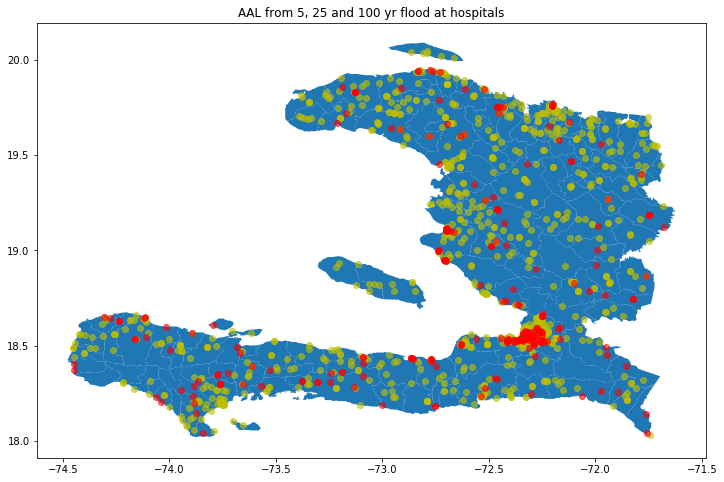

In [36]:
fig, ax = plt.subplots(1, figsize=(12,8))
base = ADM.plot(ax=ax)
no_flood = df[df['AAL_total']==0].plot(c='y',ax=ax,alpha=0.6)
flood = df[df['AAL_total']>0].plot(alpha=0.6,color='r',ax=ax)
ax.set_title('AAL from 5, 25 and 100 yr flood at hospitals')

In [39]:
df[['name','area','AAL_5yr','AAL_25yr','AAL_100yr','AAL_total']].sort_values('AAL_total',ascending=False).head(10)

,name,area,AAL_5yr,AAL_25yr,AAL_100yr,AAL_total
848,HíÇpital Franí_ais,10650.086230,195961.586632,34881.162420,9798.079332,240640.828384
745,Centre de R’©f’©rence des Urgences en Obst’©tr...,2389.722218,39134.091042,8794.177762,2198.544441,50126.813245
11,Hopital autrichien de Saint-Louis du nord,2553.401822,31478.337662,0.000000,1573.916883,33052.254545
811,HíÇpital Espoir,1134.845254,18584.225880,3716.845176,929.211294,23230.282349
856,Medical Center,961.344874,17688.745678,3537.749136,884.437284,22110.932097
852,Hospital Frances,961.344874,17688.745678,3360.861679,884.437284,21934.044641
831,H’‚pital Saint Fran’_ois de Salle,871.526877,16036.094542,2854.424829,801.804727,19692.324098
735,Medical Center near Boulevard la Saline,1113.021307,13721.326673,3645.367385,972.780622,18339.474680
832,H’‚pital de l'Universit’© d'’_tat d'Ha’Àti,871.526877,15234.289815,0.000000,713.606207,15947.896022
804,Clinique Dartiguenave,1015.904742,12524.073659,2504.814732,887.900745,15916.789136
